In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc

from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from imblearn.pipeline import Pipeline

import xgboost as xgb

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('valid.csv')

In [4]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Columns: 2666 entries, report_date to col2663
dtypes: float64(2329), int64(3), object(334)
memory usage: 74.1+ MB


In [6]:
train.head()
test.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4941670.0,4941670.0,4941670.0,NaN,NaN,NaN,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11789500.0,11789500.0,11789500.0,NaN,NaN,NaN,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7000000.0,7000000.0,7000000.0,NaN,NaN,NaN,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10391000.0,10391000.0,10391000.0,0.257348


In [7]:
# Проверка пропусков
train.isnull().sum()
test.isnull().sum()

,0
report_date,0
client_id,0
target,0
col1,3642
col2,3640
...,...
col2659,3578
col2660,1280
col2661,1280
col2662,1280


<Axes: >

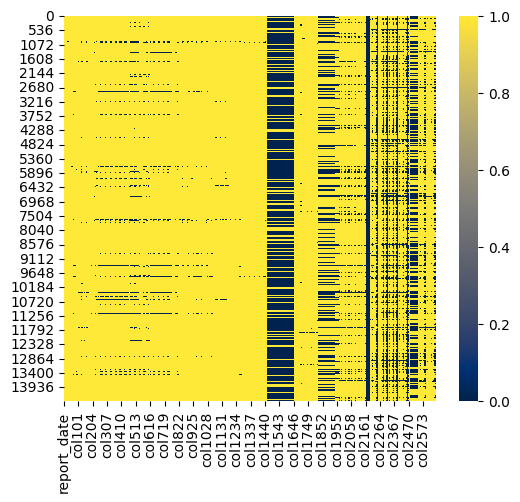

In [8]:
plt.figure(figsize=(6, 5))
sns.heatmap(train.isnull(), cmap='cividis')

<Axes: >

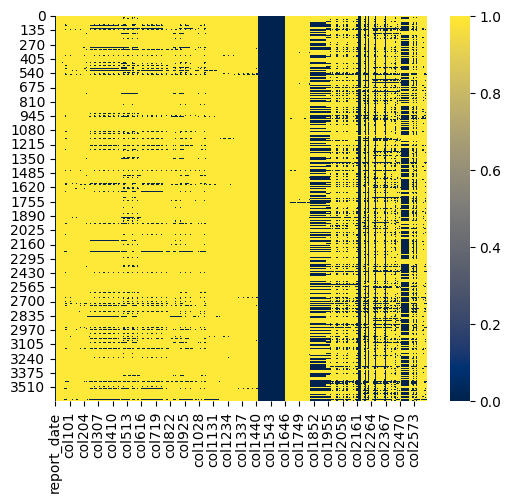

In [9]:
plt.figure(figsize=(6, 5))
sns.heatmap(test.isnull(), cmap='cividis')

In [10]:
threshold = 0.7
train_count = train.loc[:, train.isnull().mean() < threshold]
threshold = 0.7
train_count = train_count[train_count.isnull().mean(axis=1) < threshold]


In [11]:
threshold = 0.7
test_count = test.loc[:, test.isnull().mean() < threshold]
threshold = 0.7
test_count = test_count[test_count.isnull().mean(axis=1) < threshold]


print(train_count.shape)
print(test_count.shape)

(12885, 503)
(3640, 540)


In [12]:
train_count['non_null_count'] = train_count.apply(lambda row: row.count(), axis=1)


train_sort = train_count.sort_values(by='non_null_count', ascending=False)

train_sort = train_sort.head(5000)

train_sort = train_sort.drop(columns=['non_null_count'])


print(train_sort.shape)
print(test_count.shape)

(5000, 503)
(3640, 540)


In [13]:
train_sort.head(5)

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
6885,2023-01-01,5000,0,0,53872fd7-b5f6-ec11-b822-005056b8a6c4,0.0,0.0,0.0,0.0,0.0,...,360.0,360.0,360.0,6250288.0,6250288.0,6250288.0,6250288.0,6250288.0,6250288.0,0.258634
6793,2023-02-01,5879,0,0,02de0f50-bc5a-ed11-b822-005056b8a6c4,0.0,0.0,0.0,1.0,1.0,...,360.0,360.0,360.0,8145260.0,8145260.0,8145260.0,8145260.0,8145260.0,8145260.0,0.264647
5918,2022-05-01,474,1,0,1b2a9ad5-ede6-46be-b1a2-1186a40e156d,0.0,0.0,0.0,1.0,1.0,...,360.0,360.0,360.0,8126000.0,8126000.0,8126000.0,8126000.0,8126000.0,8126000.0,0.265912
8723,2023-02-01,6636,0,0,c24175f0-b259-ed11-b823-005056b8a72c,0.0,0.0,0.0,1.0,1.0,...,360.0,360.0,360.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,0.260853
2972,2023-01-01,3491,0,0,210b9249-abf6-ec11-b822-005056b8a6c4,0.0,0.0,0.0,0.0,0.0,...,240.0,240.0,240.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,0.258007


In [14]:
test_count.head(5)

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2582,col2583,col2584,col2588,col2589,col2590,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,0,01016bd5-10dc-ec11-b823-005056b825cd,0.0,0.0,0.0,0.0,0.0,...,240.0,240.0,240.0,240.0,240.0,240.0,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,0,0151dccf-0ecb-ed11-b828-005056b81dee,0.0,0.0,1.0,1.0,1.0,...,360.0,360.0,360.0,360.0,360.0,360.0,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,0,074ce8a6-859a-4084-a1c6-41343a94a856,0.0,0.0,0.0,0.0,0.0,...,348.0,348.0,348.0,348.0,348.0,348.0,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,0,08e72a9b-74fd-450a-982e-a8cede3facb3,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,0,0a033230-3889-4239-8900-0ffb7e48958c,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,362.0,362.0,362.0,10391000.0,10391000.0,10391000.0,0.257348


<Axes: >

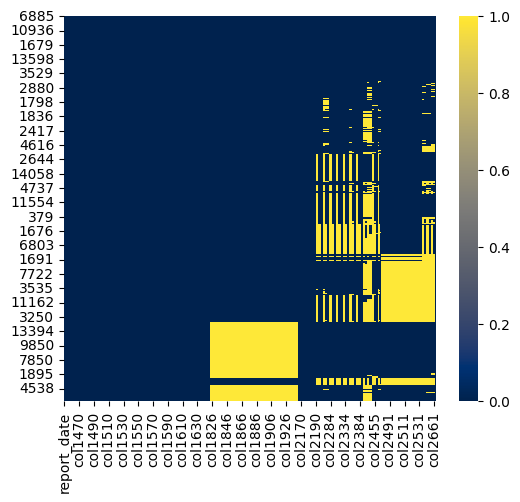

In [15]:
plt.figure(figsize=(6, 5))
sns.heatmap(train_sort.isnull(), cmap='cividis')

<Axes: >

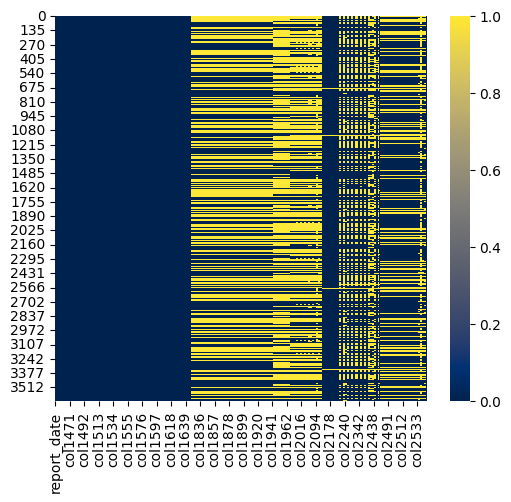

In [16]:
plt.figure(figsize=(6, 5))
sns.heatmap(test_count.isnull(), cmap='cividis')

In [17]:
columns1 = train_sort.select_dtypes('object').columns
numeric_columns = train_sort.select_dtypes(include=['float']).columns
train_sort = train_sort.drop_duplicates(subset=list(set(train_sort.columns) - set(['report_date', 'target'])))

# Заполняем пропущенные значения в категориальных переменных
for col in columns1:
    train_sort[col] = train_sort[col].fillna("unknown")

# Заполняем пропущенные значения в числовых переменных
for num_col in numeric_columns:
    mean_value = train_sort[num_col].mean()
    train_sort[num_col] = train_sort[num_col].fillna(int(mean_value))

train_sort = train_sort.apply(lambda x:x.fillna(0))

columns1 = test_count.select_dtypes('object').columns
numeric_columns = test_count.select_dtypes(include=['float']).columns
test_count = test_count.drop_duplicates(subset=list(set(test_count.columns) - set(['report_date', 'target'])))

# Заполняем пропущенные значения в категориальных переменных
for col in columns1:
    test_count[col] = test_count[col].fillna("unknown")

# Заполняем пропущенные значения в числовых переменных
for num_col in numeric_columns:
    mean_value = test_count[num_col].mean()
    test_count[num_col] = test_count[num_col].fillna(int(mean_value))

test_sort = test_count.apply(lambda x:x.fillna(0))

In [18]:
def del_duble(train_sort):
  unique_columns = []
  for column in train_sort.columns:
    if not any(train_sort[column].equals(train_sort[col]) for col in unique_columns):
      unique_columns.append(column)
  return train_sort[unique_columns]

train_sort = del_duble(train_sort)
print(train_sort.shape)

(4995, 271)


In [19]:
def del_duble(test_sort):
  unique_columns = []
  for column in test_sort.columns:
    if not any(test_sort[column].equals(test_sort[col]) for col in unique_columns):
      unique_columns.append(column)
  return test_sort[unique_columns]

test_sort = del_duble(test_sort)
print(test_sort.shape)

(3630, 290)


<Axes: >

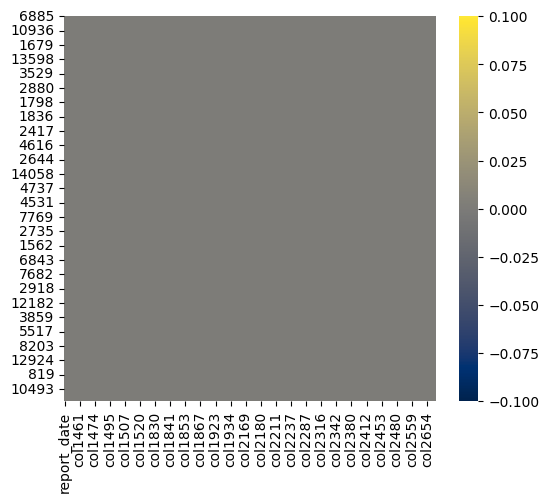

In [20]:
plt.figure(figsize=(6, 5))
sns.heatmap(train_sort.isnull(), cmap='cividis')

<Axes: >

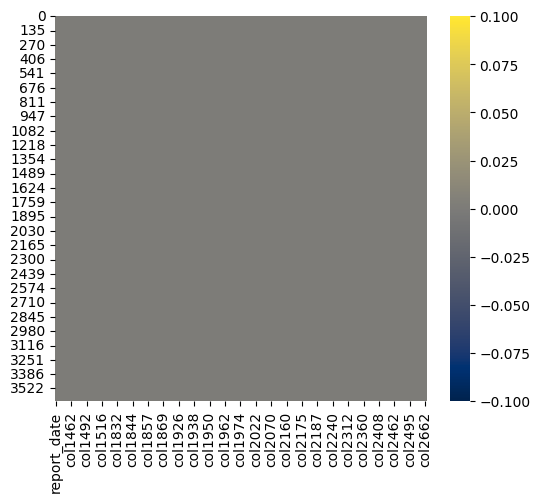

In [21]:
plt.figure(figsize=(6, 5))
sns.heatmap(test_sort.isnull(), cmap='cividis')

In [22]:
non_numeric_columns = train_sort.select_dtypes(exclude=['number'])
print("Нечисловые колонки тренировки:")
print(non_numeric_columns)
non_numeric_columns = test_sort.select_dtypes(exclude=['number'])
print("Нечисловые колонки теста:")
print(non_numeric_columns)

Нечисловые колонки тренировки:
      report_date                               col1454
6885   2023-01-01  53872fd7-b5f6-ec11-b822-005056b8a6c4
6793   2023-02-01  02de0f50-bc5a-ed11-b822-005056b8a6c4
5918   2022-05-01  1b2a9ad5-ede6-46be-b1a2-1186a40e156d
8723   2023-02-01  c24175f0-b259-ed11-b823-005056b8a72c
2972   2023-01-01  210b9249-abf6-ec11-b822-005056b8a6c4
...           ...                                   ...
12812  2022-05-01  6c851050-8025-4a3e-9cec-604b380bced3
11429  2022-04-01  7e456615-f4d1-49fe-998e-1140e14188d4
13372  2022-04-01  6200165e-24cf-47b8-adb8-0f88311ceba9
5117   2022-06-01  59e6b55b-2ce7-40d6-b6ca-42a966c02855
3631   2022-03-01  5b494ce5-88b4-40ce-84ef-1a74147dd6f8

[4995 rows x 2 columns]
Нечисловые колонки теста:
     report_date                               col1454
0     2023-04-01  01016bd5-10dc-ec11-b823-005056b825cd
1     2023-05-01  0151dccf-0ecb-ed11-b828-005056b81dee
2     2023-05-01  074ce8a6-859a-4084-a1c6-41343a94a856
3     2023-03-01  08e72a9b

In [66]:
tr_client1 = train_sort[train_sort['client_id'] == 1488]
tr_client2 = train_sort[train_sort['client_id'] == 228]

tr_client1

,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,col1461,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
10936,1488,0,0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,...,50.0,50.0,50.0,1376700.0,1376700.0,1376700.0,1376700.0,1376700.0,1376700.0,0.256919
1047,1488,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,50.0,50.0,50.0,1376700.0,1376700.0,1376700.0,1376700.0,1376700.0,1376700.0,0.256919
7240,1488,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,50.0,50.0,50.0,1376700.0,1376700.0,1376700.0,1376700.0,1376700.0,1376700.0,0.256919
1926,1488,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,50.0,50.0,50.0,7459672.0,7311909.0,7384674.0,1376700.0,1376700.0,1376700.0,0.256919


In [67]:
tr_client2

,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,col1461,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
7768,228,0,0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,144.0,144.0,144.0,7473565.0,7473565.0,7473565.0,7473565.0,7473565.0,7473565.0,0.253216


In [25]:
test_sort.drop(['report_date'], axis = 1, inplace = True)
test_sort.drop(['col1454'], axis = 1, inplace = True)
test_sort.drop(['col2663'], axis = 1, inplace = True)
train_sort.drop(['report_date'], axis = 1, inplace = True)
train_sort.drop(['col1454'], axis = 1, inplace = True)

In [26]:
print("Количество пропущенных значений в тренировочном файле:")
print(train_sort.isnull().sum())
print("Количество пропущенных значений в тестировочном файле:")
print(test_sort.isnull().sum())

Количество пропущенных значений в тренировочном файле:
client_id    0
target       0
col1453      0
col1455      0
col1456      0
            ..
col2656      0
col2660      0
col2661      0
col2662      0
col2663      0
Length: 269, dtype: int64
Количество пропущенных значений в тестировочном файле:
client_id    0
target       0
col1453      0
col1455      0
col1456      0
            ..
col2589      0
col2590      0
col2660      0
col2661      0
col2662      0
Length: 287, dtype: int64


Переход к моделям

In [27]:
test_sort = train_sort[train_sort.columns.intersection(train_sort.columns)]
missing_columns = set(train_sort.columns) - set(test_sort.columns)

for col in missing_columns:
    test_sort[col] = 0  # Или другое значение, например, среднее/медиану по обучающему набору

# Приводим порядок колонок к обучающему набору
test_sort = test_sort[train_sort.columns]

print(train_sort.shape)
print(test_sort.shape)

(4995, 269)
(4995, 269)


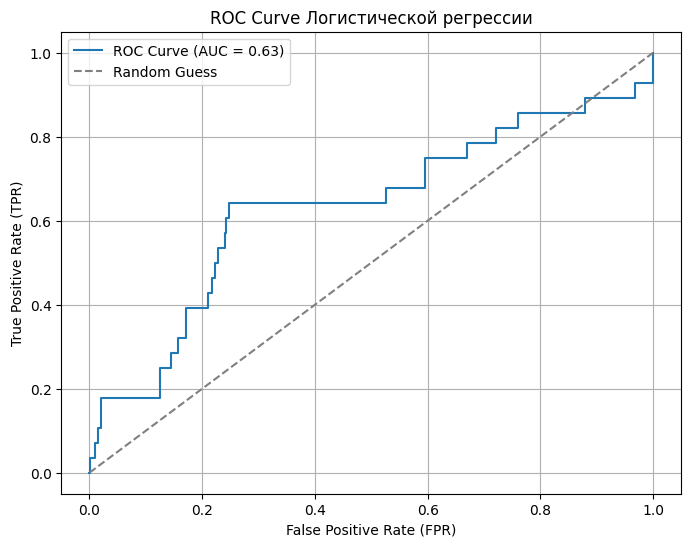

In [28]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = train_sort.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y = train_sort['target']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model1 = LogisticRegression(class_weight="balanced", random_state=101, max_iter=1000)
model1.fit(X_train, y_train)

# Предсказание вероятностей для тестовой выборки
y_pred_proba = model1.predict_proba(X_test)[:, 1]

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Вычисление AUC (Area Under Curve)
auc1 = roc_auc_score(y_test, y_pred_proba)

# Построение ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc1:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Логистической регрессии')
plt.legend()
plt.grid()
plt.show()

In [29]:
# Разделение данных
X = train_sort.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y = train_sort['target']

# Разделение данных на обучающую и тестовую выборки с учетом баланса классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Определение категориальных столбцов
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Кодирование категориальных переменных
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_columns] = ordinal_encoder.fit_transform(X_train[categorical_columns].astype(str))
X_test[categorical_columns] = ordinal_encoder.transform(X_test[categorical_columns].astype(str))

# Создание модели
random_forest_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    max_features='sqrt',
    bootstrap=True,
    oob_score=True
)

# Создание пайплайна с балансировкой классов и моделью
pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=42)),  # Балансировка классов
    ('rf', random_forest_model)
])

# Определение гиперпараметров для поиска
param_distributions = {
    'rf__n_estimators': [50, 75, 100],
    'rf__max_depth': [3, 4, 5],
    'rf__min_samples_split': [30, 40, 50],
    'rf__min_samples_leaf': [20, 30, 40],
    'rf__class_weight': ['balanced']
}

# Поиск лучших гиперпараметров с использованием RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1
)

# Обучение модели
random_search.fit(X_train, y_train)

# Оценка на тестовых данных
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Вывод результатов
print("Лучшие параметры модели:", random_search.best_params_)
print("\nROC-AUC на тестовых данных:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report на тестовых данных:\n", classification_report(y_test, best_model.predict(X_test)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры модели: {'rf__n_estimators': 100, 'rf__min_samples_split': 40, 'rf__min_samples_leaf': 20, 'rf__max_depth': 5, 'rf__class_weight': 'balanced'}

ROC-AUC на тестовых данных: 0.82519292301901

Classification Report на тестовых данных:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       966
           1       0.14      0.45      0.21        33

    accuracy                           0.89       999
   macro avg       0.56      0.68      0.58       999
weighted avg       0.95      0.89      0.92       999




ROC-AUC на valid данных: 0.9061151891586674

Classification Report на valid данных:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      4830
           1       0.21      0.66      0.31       165

    accuracy                           0.90      4995
   macro avg       0.60      0.79      0.63      4995
weighted avg       0.96      0.90      0.93      4995



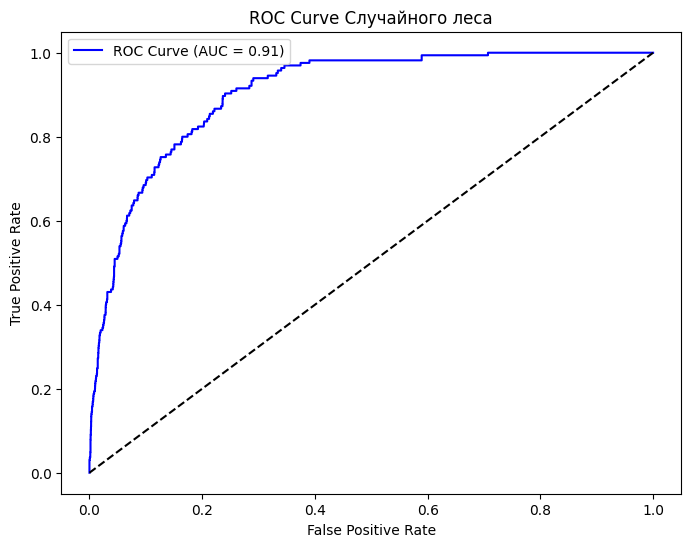

In [30]:
# Разделение данных
X_valid = test_sort.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = test_sort['target']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Определение категориальных столбцов
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Градиентный бустинг
gbc = GradientBoostingClassifier(random_state=42)
gbc_scores = cross_val_score(gbc, X_train, y_train, cv=5, scoring='roc_auc')

# Кодирование категориальных признаков
X_valid[categorical_columns] = ordinal_encoder.transform(X_valid[categorical_columns].astype(str))

# Предсказание на valid_no_duplicates
y_valid_pred = best_model.predict(X_valid)
y_valid_pred_proba = best_model.predict_proba(X_valid)[:, 1]

# Оценка модели на valid
roc_auc_valid = roc_auc_score(y_valid, y_valid_pred_proba)
print("\nROC-AUC на valid данных:", roc_auc_valid)
print("\nClassification Report на valid данных:\n", classification_report(y_valid, y_valid_pred))

# Визуализация ROC-AUC
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred_proba)
roc_auc_valid_curve = auc(fpr_valid, tpr_valid)

# Визуализация ROC-кривой на валидационной выборке
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_valid:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Случайного леса')
plt.legend()
plt.show()

In [31]:
df_ones = test_sort[test_sort['target'] == 1]

df_zeros = test_sort[test_sort['target'] == 0].head(66)

filtered_df = pd.concat([df_zeros, df_ones])

valid_df = filtered_df.reset_index(drop=True)
valid_df

,client_id,target,col1453,col1455,col1456,col1457,col1458,col1459,col1460,col1461,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
0,5000,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,360.0,360.0,360.0,6250288.0,6250288.0,6250288.0,6250288.0,6250288.0,6250288.0,0.258634
1,5879,0,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,360.0,360.0,360.0,8145260.0,8145260.0,8145260.0,8145260.0,8145260.0,8145260.0,0.264647
2,6636,0,0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,360.0,360.0,360.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,0.260853
3,3491,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,240.0,240.0,240.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,0.258007
4,6232,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,360.0,360.0,360.0,8419200.0,8419200.0,8419200.0,8419200.0,8419200.0,8419200.0,0.268703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,4246,1,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,242.0,242.0,242.0,8000000.0,8000000.0,8000000.0,8000000.0,8000000.0,8000000.0,0.256061
227,1049,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,180.0,180.0,180.0,13199998.0,13199998.0,13199998.0,13199998.0,13199998.0,13199998.0,0.256061
228,6089,1,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,242.0,242.0,242.0,8370000.0,8370000.0,8370000.0,8370000.0,8370000.0,8370000.0,0.256061
229,2422,1,0,0.0,3.0,3.0,3.0,3.0,3.0,3.0,...,240.0,240.0,240.0,6500000.0,6500000.0,6500000.0,6500000.0,6500000.0,6500000.0,0.256061


In [32]:
X_train = train_sort.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_train = train_sort['target']

X_val = valid_df.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_val = valid_df['target']
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'max_depth': 1,  # Увеличиваем глубину деревьев
    'learning_rate': 0.1,  # Уменьшаем скорость обучения
    'n_estimators': 100,  # Большее количество итераций
    'subsample': 0.6,  # Используем только часть данных на каждой итерации
    'colsample_bytree': 0.8,  # Используем часть признаков
    'gamma': 1,  # Добавляем регуляризацию
    'random_state': 1
}

In [33]:
model3 = xgb.train(params, dtrain, num_boost_round=100)

In [34]:
#предсказание valid данных
y_prob = model3.predict(dval)

fpr, tpr, trashers = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

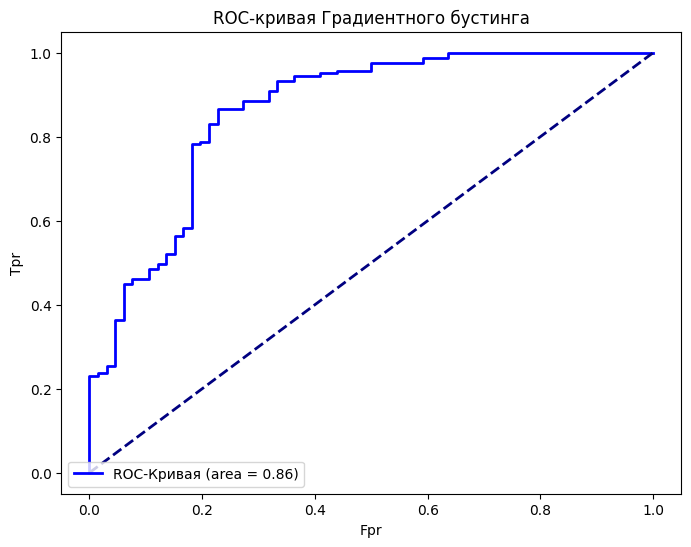

In [35]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-Кривая (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Fpr')
plt.ylabel('Tpr')
plt.title('ROC-кривая Градиентного бустинга')
plt.legend(loc='lower left')
plt.show()

In [36]:
# Сохранение результатов
submission = pd.DataFrame({'client_id': train_sort.loc[X_test.index, 'client_id'], 'score': y_pred_proba})
submission.to_csv('submission_file.csv', index=False)

# Проверка первых строк файла
print(submission.head())

# Проверка на наличие пропусков
print(submission.isnull().sum())

       client_id     score
13555       2943  0.140297
2388        2979  0.253168
9980         110  0.225764
9746         612  0.111067
9239        4859  0.125478
client_id    0
score        0
dtype: int64
